In [0]:
file_path = "dbfs:/user/hive/warehouse/group2.db/machine_state_table_combined"
# group2.machine_state_combined
df_combined = spark.read.format("delta").option("header", "true").load(file_path)

In [0]:
display(df_combined.limit(6))

enqueued_time_utc,connection_device_id,e_prog_runn,e_prog_wait,ch_1_prog_pfad_name,ch_1_line_content,ch_1_tool_ident,vorschuboverride,eilgangoverride,spindeloverride,ch_1_act_speed_s_1,nc_start_counter,act_prog_net_time,old_prog_net_time,bag_1_op_mode,Machine_state,day_of_week,hour,minute,Shift,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,minute_sin,minute_cos
2022-01-01T00:16:42.116Z,oelde-11319,false,false,/_N_SYF_DIR/_N_OSTORE1_SYF,,,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,7,0,16,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9945218953682734,-0.10452846326765333
2022-01-01T00:16:49.569Z,oelde-36103,false,false,/_N_SYF_DIR/_N_OSTORE1_SYF,,,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,7,0,16,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9945218953682734,-0.10452846326765333
2022-01-01T00:17:03.398Z,oelde-11319,false,false,/_N_SYF_DIR/_N_OSTORE1_SYF,,,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,7,0,17,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:17:09.851Z,oelde-36103,false,false,/_N_SYF_DIR/_N_OSTORE1_SYF,,,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,7,0,17,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:17:23.033Z,oelde-11319,false,false,/_N_SYF_DIR/_N_OSTORE1_SYF,,,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,7,0,17,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:17:42.315Z,oelde-11319,false,false,/_N_SYF_DIR/_N_OSTORE1_SYF,,,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,7,0,17,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934


In [0]:
categorical_columns = ["e_prog_runn", "e_prog_wait","bag_1_op_mode", "Machine_state", "Shift"]

In [0]:
numerical_columns = ["vorschuboverride", "eilgangoverride", "spindeloverride", "ch_1_act_speed_s_1", "nc_start_counter", "act_prog_net_time", "old_prog_net_time", "hour_sin", "hour_cos", "day_of_week_sin", "day_of_week_cos", "minute_sin", "minute_cos"]


In [0]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [0]:
# Function to apply Isolation Forest to each unique connection_device_id
def apply_isolation_forest(df, connection_device_id):
    # Filter data for the specific connection_device_id
    df_filtered = df.filter(col("connection_device_id") == connection_device_id)

    # Convert to pandas dataframe
    pdf_filtered = df_filtered.toPandas()
    # OneHotEncode categorical columns
    for column in categorical_columns:
        pdf_filtered = pd.get_dummies(pdf_filtered, columns=[column], prefix=[column])

    # Standardize numerical columns
    scaler = StandardScaler()
    pdf_filtered[numerical_columns] = scaler.fit_transform(pdf_filtered[numerical_columns])

    # Exclude DateTime64 columns
    columns_to_exclude = ["connection_device_id", "anomaly", "anomaly_score"] + \
                         [col for col in pdf_filtered.columns if pd.api.types.is_datetime64_any_dtype(pdf_filtered[col])]
    columns_to_include = [col for col in pdf_filtered.columns if col not in columns_to_exclude]

    # Apply Isolation Forest
    isolation_forest = IsolationForest(contamination=0.05, random_state=42)
    pdf_filtered['anomaly'] = isolation_forest.fit_predict(pdf_filtered[columns_to_include])
    pdf_filtered['anomaly_score'] = isolation_forest.decision_function(pdf_filtered[columns_to_include])

    # Convert back to Spark DataFrame
    df_result = spark.createDataFrame(pdf_filtered)

    return df_result

In [0]:
df_combined2 = df_combined.drop("day_of_week", "hour", "minute","ch_1_prog_pfad_name", "ch_1_line_content", "ch_1_tool_ident")

In [0]:
# display(df_combined2.limit(20))

enqueued_time_utc,connection_device_id,e_prog_runn,e_prog_wait,vorschuboverride,eilgangoverride,spindeloverride,ch_1_act_speed_s_1,nc_start_counter,act_prog_net_time,old_prog_net_time,bag_1_op_mode,Machine_state,Shift,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,minute_sin,minute_cos
2022-01-01T00:16:42.116Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9945218953682734,-0.10452846326765333
2022-01-01T00:16:49.569Z,oelde-36103,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9945218953682734,-0.10452846326765333
2022-01-01T00:17:03.398Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:17:09.851Z,oelde-36103,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:17:23.033Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:17:42.315Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9781476007338057,-0.20791169081775934
2022-01-01T00:18:02.253Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9510565162951536,-0.30901699437494734
2022-01-01T00:18:22.21Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,101.0,0.0,3669.291,0.0,SETUP,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9510565162951536,-0.30901699437494734
2022-01-01T00:18:42.882Z,oelde-11319,false,false,0.0,0.0,100.0,0.0,1265.0,0.0,23872.035,2.0,AUTOMATIC_INACTIVE,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9510565162951536,-0.30901699437494734
2022-01-01T00:18:48.742Z,oelde-36103,false,false,0.0,0.0,100.0,0.0,1265.0,0.0,23872.035,2.0,AUTOMATIC_INACTIVE,Night_shift,0.0,1.0,-2.4492935982947064E-16,1.0,0.9510565162951536,-0.30901699437494734


In [0]:
# Get unique connection_device_ids
# contamination 0.05
connection_device_ids = df_combined2.select("connection_device_id").distinct().rdd.flatMap(lambda x: x).collect()

# Apply Isolation Forest to each unique connection_device_id
df_results2 = [apply_isolation_forest(df_combined2, connection_device_id) for connection_device_id in connection_device_ids]



Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [0]:
# Get unique connection_device_ids
# contamination 0.1
connection_device_ids = df_combined2.select("connection_device_id").distinct().rdd.flatMap(lambda x: x).collect()

# Apply Isolation Forest to each unique connection_device_id
df_results = [apply_isolation_forest(df_combined2, connection_device_id) for connection_device_id in connection_device_ids]



Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/spark/python/pyspark/sql/pandas/conversion.py:510: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field e_prog_runn_False. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [0]:

from pyspark.sql.functions import lit
from pyspark.sql.types import StringType

# Ensure all DataFrames have the same columns
all_columns = set()
for df in df_results2:
    all_columns.update(df.columns)

all_columns = list(all_columns)

def add_missing_columns(df, all_columns):
    for column in all_columns:
        if column not in df.columns:
            df = df.withColumn(column, lit(None).cast(StringType()))
    # Escape column names with backticks
    return df.select([f"`{column}`" for column in all_columns])

df_results2 = [add_missing_columns(df, all_columns) for df in df_results2]

# Combine results
df_final = df_results2[0]
for df in df_results2[1:]:
    df_final = df_final.union(df)


In [0]:

display(df_final.limit(100))

Shift_First_shift,bag_1_op_mode_1.0,Machine_state_AUTOMATIC_ACTIVE,act_prog_net_time,minute_sin,eilgangoverride,Machine_state_AUTOMATIC_INACTIVE,Machine_state_SETUP,spindeloverride,connection_device_id,old_prog_net_time,anomaly_score,hour_cos,e_prog_runn_True,bag_1_op_mode_2.0,anomaly,Shift_Night_shift,bag_1_op_mode_0.0,vorschuboverride,day_of_week_cos,ch_1_act_speed_s_1,day_of_week_sin,nc_start_counter,Machine_state_MANUAL,e_prog_runn_False,e_prog_wait_True,minute_cos,hour_sin,e_prog_wait_False,enqueued_time_utc,Shift_Second_shift
1,0,1,-0.2948815780048427,-0.82707552645488,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,-0.21599518789758487,0.11360407919728821,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-5.201883516328993,-1.1688289485526162,-0.49726846239207023,0,0,0,-1.1433813917619136,1.191818267759534,1,2022-04-21T08:36:32.812Z,0
1,0,1,-0.33100134077806165,-0.82707552645488,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,-0.21599518789758487,0.1317927218836491,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-1.502422850020571,-1.1688289485526162,-0.47850484598605997,0,0,0,-1.1433813917619136,1.191818267759534,1,2022-04-21T08:36:53.788Z,0
1,0,1,-0.30550327488108375,-0.9421181869544257,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,0.20069771713435774,0.12599495070221073,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.3283959147379781,0,0,0,-1.0502256261607108,1.191818267759534,1,2022-04-21T08:37:53.696Z,0
1,0,1,-0.36873103119474704,-1.046792790438773,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,-0.21599518789758487,0.14405482440930079,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.3364374646262682,0,0,0,-0.945555454178284,1.191818267759534,1,2022-04-21T08:38:11.691Z,0
1,0,1,4.549931381836046,-1.046792790438773,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,0.567285493302527,0.07157895350694782,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.2828271320376675,0,0,0,-0.945555454178284,1.191818267759534,1,2022-04-21T08:38:53.61Z,0
1,0,1,-0.3207277708298732,-1.1399525000475792,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,-0.21599518789758487,0.1437861429949321,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.010754694150519092,0,0,0,-0.830517664122513,1.191818267759534,1,2022-04-21T08:39:14.278Z,0
1,0,0,-0.4246417460682434,-1.1399525000475792,0.42178147880123373,1,0,0.07627449100067675,buechen-71316,-0.21225298123253408,0.1270946309808793,-0.7122961722800948,0,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.17426620854575114,0,1,0,-0.830517664122513,1.191818267759534,1,2022-04-21T08:39:35.279Z,0
1,0,1,-0.1826514497946968,-1.1399525000475792,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,-0.001008296616535165,0.03802797475247233,-0.7122961722800948,0,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,0.042855638438081586,0,1,1,-0.830517664122513,1.191818267759534,0,2022-04-21T08:39:56.224Z,0
1,0,1,0.29855177846925174,-1.2205766385074466,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,-0.21599518789758487,0.13657475246271217,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.4436581298034696,0,0,0,-0.7063726340944553,1.191818267759534,1,2022-04-21T08:40:35.183Z,0
1,0,1,-0.026079769915292116,-1.2877818708857243,0.42178147880123373,0,0,0.07627449100067675,buechen-71316,3.536421225016209,0.0421128261911029,-0.7122961722800948,1,1,1,0,0,0.38597540279984366,0.26210572673372695,-0.11260678848879681,-1.1688289485526162,-0.3015907484436778,0,0,0,-0.5744805230221153,1.191818267759534,1,2022-04-21T08:41

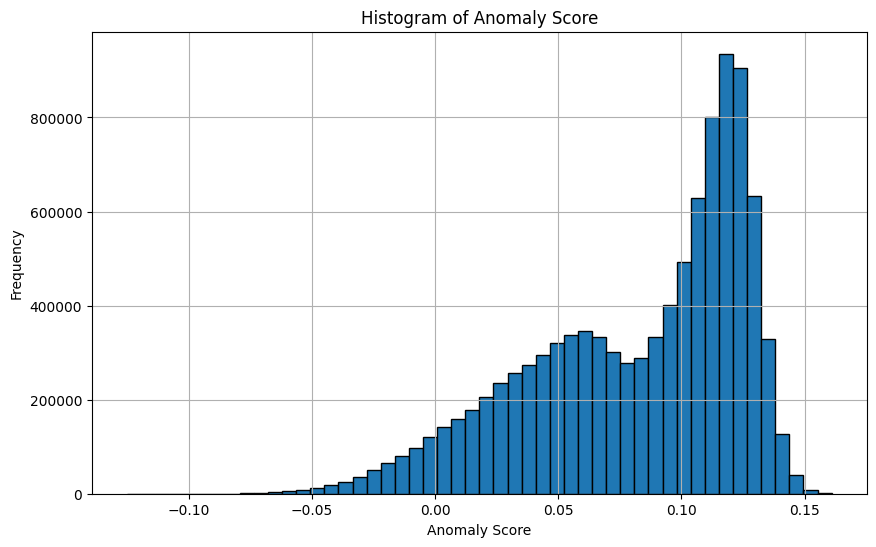

In [0]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
df_pandas = df_final.select("anomaly_score").toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_pandas["anomaly_score"], bins=50, edgecolor='k')
plt.title("Histogram of Anomaly Score")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

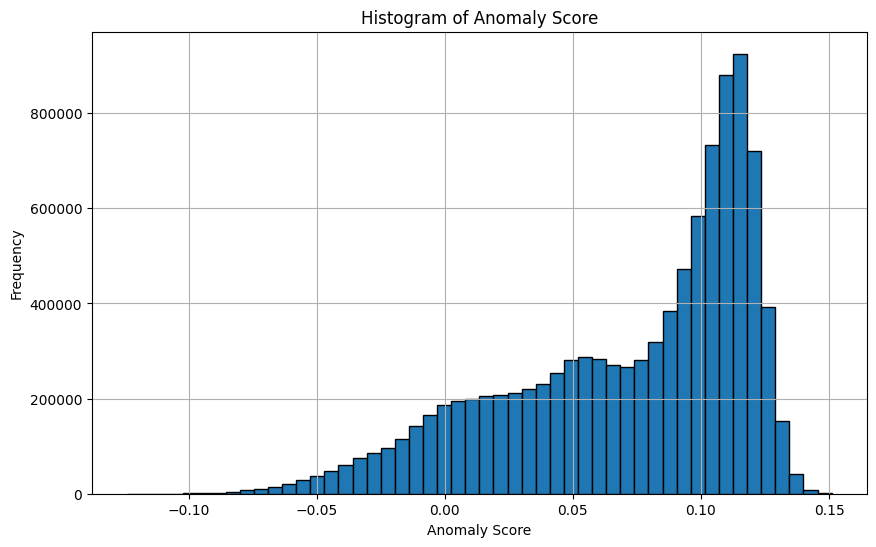

In [0]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
df_pandas = df_final.select("anomaly_score").toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_pandas["anomaly_score"], bins=50, edgecolor='k')
plt.title("Histogram of Anomaly Score")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

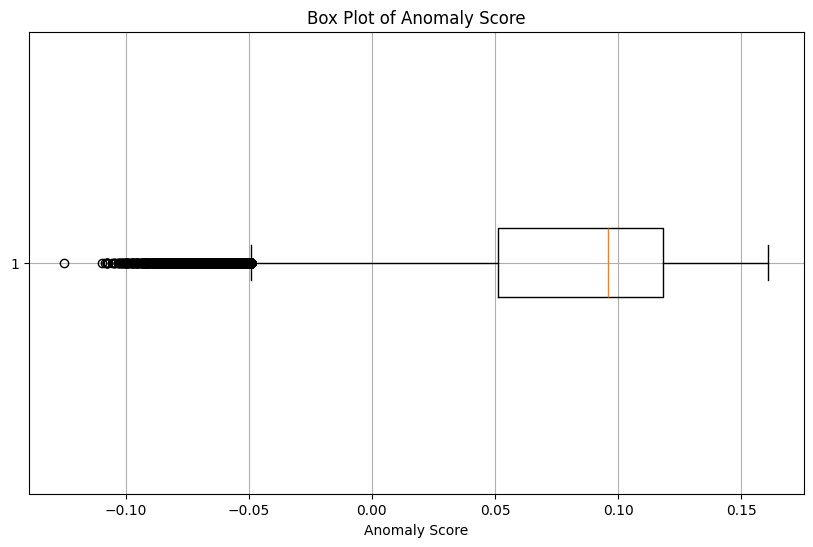

In [0]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
df_pandas = df_final.select("anomaly_score").toPandas()

# Plot the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_pandas["anomaly_score"], vert=False)
plt.title("Box Plot of Anomaly Score")
plt.xlabel("Anomaly Score")
plt.grid(True)
plt.show()

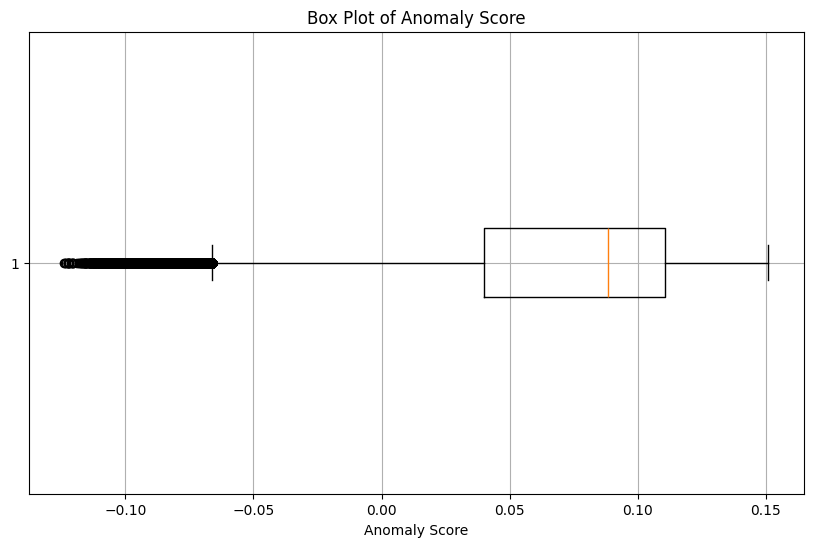

In [0]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
df_pandas = df_final.select("anomaly_score").toPandas()

# Plot the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_pandas["anomaly_score"], vert=False)
plt.title("Box Plot of Anomaly Score")
plt.xlabel("Anomaly Score")
plt.grid(True)
plt.show()

In [0]:
# df_final.write.saveAsTable("group2.machine_state_table_combined_with_anomalies_5")